In [1]:
!wget https://raw.githubusercontent.com/facebookresearch/ConvNeXt/main/models/convnext.py

--2024-05-26 18:56:57--  https://raw.githubusercontent.com/facebookresearch/ConvNeXt/main/models/convnext.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9321 (9.1K) [text/plain]
Saving to: ‘convnext.py.4’

convnext.py.4       100%[===================>]   9.10K  --.-KB/s    in 0s      

2024-05-26 18:56:57 (57.4 MB/s) - ‘convnext.py.4’ saved [9321/9321]



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from convnext import ConvNeXt
from fastprogress.fastprogress import master_bar, progress_bar
from torchvision.transforms import RandomResizedCrop, CenterCrop, Resize, RandomHorizontalFlip, Compose
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

/home/dgj335/.local/lib/python3.10/site-packages/beartype/_util/error/utilerrwarn.py:67: BeartypeModuleUnimportableWarning: Ignoring module "onnx" importation exception:
    ImportError: cannot import name 'builder' from 'google.protobuf.internal' (/home/dgj335/.local/lib/python3.10/site-packages/google/protobuf/internal/__init__.py)
  warn(message, cls)
/home/dgj335/.local/lib/python3.10/site-packages/beartype/_util/error/utilerrwarn.py:67: BeartypeModuleUnimportableWarning: Ignoring module "onnx" importation exception:
    ImportError: cannot import name 'builder' from 'google.protobuf.internal' (/home/dgj335/.local/lib/python3.10/site-packages/google/protobuf/internal/__init__.py)
  warn(message, cls)
/home/dgj335/danjacobellis/BF/convnext.py:159: UserWarning: Overwriting convnext_tiny in registry with convnext.convnext_tiny. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_tiny(pretrained=False,in_22k=Fa

In [3]:
train_dataset = load_dataset("imagenet-1k",split="train",trust_remote_code=True)
valid_dataset = load_dataset("imagenet-1k",split="validation",trust_remote_code=True)
rgb_train = train_dataset.filter(lambda s: s["image"].mode == "RGB").with_format("torch")
rgb_valid = valid_dataset.filter(lambda s: s["image"].mode == "RGB").with_format("torch")

Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

In [4]:
def custom_collate_fn(batch):
    train_transforms = Compose(
        [
            RandomResizedCrop(256, scale=(0.5,1.0), ratio=(0.8, 1.25)),
            RandomHorizontalFlip(),
        ]
    )
    images = torch.stack([train_transforms(item['image'].permute(2,0,1).to(torch.float)/255) for item in batch])
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.int64)
    return images, labels

val_transforms = Compose(
    [
        Resize(256,antialias=True),
        CenterCrop(256),
    ]
)

In [5]:
classifier = ConvNeXt(in_chans=3,
                      num_classes=1000,
                      depths=[3, 3, 9, 3],
                      dims=[96, 192, 384, 768],
                      drop_path_rate=0.,
                      layer_scale_init_value=1e-6,
                      head_init_scale=1.).cuda()

In [6]:
epochs = 100
batch_size = 144
accumulation_steps = 1152//batch_size

loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(classifier.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

train_loss = []
test_loss = []
val_accuracy = []

/home/dgj335/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 1, Accuracy: 0.1107


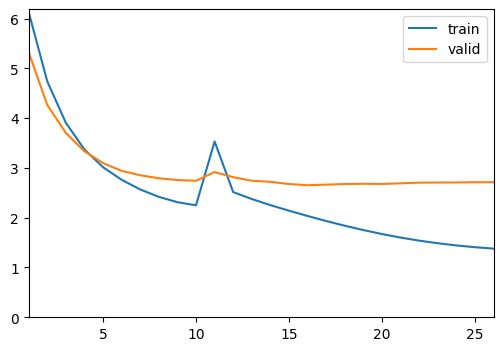

/home/dgj335/.local/lib/python3.10/site-packages/fastprogress/fastprogress.py:206: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  if x_bounds is not None: self.graph_ax.set_xlim(*x_bounds)


Epoch: 2, Accuracy: 0.2622
Epoch: 3, Accuracy: 0.3681
Epoch: 4, Accuracy: 0.4385
Epoch: 5, Accuracy: 0.4914
Epoch: 6, Accuracy: 0.5285
Epoch: 7, Accuracy: 0.5487
Epoch: 8, Accuracy: 0.5648
Epoch: 9, Accuracy: 0.5755
Epoch: 10, Accuracy: 0.5806
Epoch: 11, Accuracy: 0.5311
Epoch: 12, Accuracy: 0.5536
Epoch: 13, Accuracy: 0.5721
Epoch: 14, Accuracy: 0.5797
Epoch: 15, Accuracy: 0.5918
Epoch: 16, Accuracy: 0.5974
Epoch: 17, Accuracy: 0.6010
Epoch: 18, Accuracy: 0.6010
Epoch: 19, Accuracy: 0.6045
Epoch: 20, Accuracy: 0.6087
Epoch: 21, Accuracy: 0.6085
Epoch: 22, Accuracy: 0.6082
Epoch: 23, Accuracy: 0.6102
Epoch: 24, Accuracy: 0.6117
Epoch: 25, Accuracy: 0.6114
Epoch: 26, Accuracy: 0.6148


Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x749578541510>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 106, in remove
    def remove(wr, selfref=ref(self), _atomic_removal=_remove_dead_weakref):
KeyboardInterrupt: 

KeyboardInterrupt



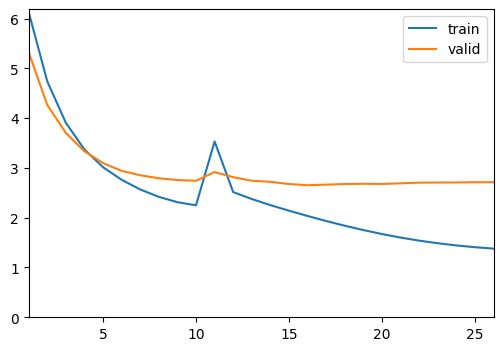

In [7]:
mb = master_bar(range(1, epochs + 1))

for epoch in mb:
    
    dataloader_train = DataLoader(rgb_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12, collate_fn=custom_collate_fn)
    dataloader_valid = DataLoader(rgb_valid, batch_size=1, shuffle=False, drop_last=False)

    # Training
    classifier.train()
    optimizer.zero_grad()
    running_loss = 0.0
    for i_batch, (x, target) in enumerate(progress_bar(dataloader_train, parent=mb)):
        x = x.cuda()
        outputs = classifier(x)
        loss = loss_function(outputs, target.cuda())
        loss.backward()
        print(loss.item(), end='\r')
        running_loss += loss.item()

        if (i_batch + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    train_epoch_loss = running_loss / len(dataloader_train)
    train_loss.append(train_epoch_loss)
    
    # Validation
    classifier.eval()
    running_loss_val = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs in dataloader_valid:
            x = inputs['image'].permute(0,3,1,2).to(torch.float)/255
            x = val_transforms(x).cuda()
            targets = inputs['label'].to(torch.int64).cuda()
            outputs = classifier(x)
            loss = loss_function(outputs, targets)
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)
    val_epoch_loss = running_loss_val / len(dataloader_valid)
    test_loss.append(val_epoch_loss)
    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch: {epoch}, Accuracy: {epoch_accuracy:.4f}')
    val_accuracy.append(epoch_accuracy)
    graphs = [
        [range(1, epoch + 1), train_loss],  # Training Loss
        [range(1, epoch + 1), test_loss],  # Validation Loss
    ]
    x_bounds = [1, epoch]
    y_bounds = [min(min(train_loss + test_loss) - 0.05, 0), max(max(train_loss + test_loss) + 0.05, 1)]
    mb.update_graph(graphs, x_bounds, y_bounds)
    scheduler.step()

In [8]:
checkpoint_filename = f'convnext_imagenet1k_e{epoch-1}.pt'
checkpoint = {
    'model_state_dict': classifier.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'epoch': epoch,
    'train_loss': train_loss,
    'test_loss': test_loss,
    'val_accuracy': val_accuracy
}
torch.save(checkpoint, checkpoint_filename)